# Bike Sharing Demand
- Forecast use of a city bikeshare system
- https://www.kaggle.com/c/bike-sharing-demand/data

## Credit to:
- 

In [151]:
# data processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
from scipy import stats
from scipy.stats import norm
import math
from numpy import sort

# ML
# # Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
# # XGB
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance
# # CatBoost
#from catboost import Pool, CatBoostRegressor, cv, CatboostIpythonWidget
# System
import datetime as dt
from datetime import datetime
import sys
from inspect import getsourcefile
import os.path
import re


# Other
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

# Load data

In [2]:
# Load data. Download from:https://www.kaggle.com/c/bike-sharing-demand/data
train_data = pd.read_csv(DATA_DIR + "/train.csv")
eval_data =  pd.read_csv(DATA_DIR + "/test.csv")

In [3]:
train_data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
eval_data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Combine train data and eval data

In [230]:
label = 'count'
features = eval_data.columns.values
target = train_data[label].values
combine_data = pd.concat([train_data[features], eval_data], keys=['train','eval'])
combine_data.head(5)

datetime  season  holiday  workingday  weather  temp  \
train 0  2011-01-01 00:00:00       1        0           0        1  9.84   
      1  2011-01-01 01:00:00       1        0           0        1  9.02   
      2  2011-01-01 02:00:00       1        0           0        1  9.02   
      3  2011-01-01 03:00:00       1        0           0        1  9.84   
      4  2011-01-01 04:00:00       1        0           0        1  9.84   

          atemp  humidity  windspeed  
train 0  14.395        81        0.0  
      1  13.635        80        0.0  
      2  13.635        80        0.0  
      3  14.395        75        0.0  
      4  14.395        75        0.0

# Pre-process data

### Check NaN columns

In [6]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = combine_data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [7]:
# Check target for null
check_null_data(target)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [8]:
# combine data for null
check_null_data(combine_data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [9]:
combine_data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

### Convert datetime string to object

In [31]:
def pd_datetime(data):
    date_format = "%Y-%m-%d %H:%M:%S"
    datetime_obj = data['datetime'].apply(lambda x: datetime.strptime(x, date_format))
    return datetime_obj 

In [231]:
#date_format = "%Y-%m-%d %H:%M:%S"
data = combine_data
data['datetime_obj'] = pd_datetime(data)
#data['datetime_obj'] = data['datetime'].apply(lambda x: datetime.strptime(x, date_format))
data['datetime_obj'][:5]

train  0   2011-01-01 00:00:00
       1   2011-01-01 01:00:00
       2   2011-01-01 02:00:00
       3   2011-01-01 03:00:00
       4   2011-01-01 04:00:00
Name: datetime_obj, dtype: datetime64[ns]

### Extract date component from datatime object

In [227]:
dt_obj = datetime.strptime('2011-01-01 00:00:00', date_format)
dt_obj.weekday()

5

In [232]:
data['year'] = data['datetime_obj'].apply(lambda x: x.year)
data['month'] = data['datetime_obj'].apply(lambda x: x.month)
data['day'] = data['datetime_obj'].apply(lambda x: x.day)
data['hour'] = data['datetime_obj'].apply(lambda x: x.hour)
data['weekday'] = data['datetime_obj'].apply(lambda x: x.weekday())
data[:5]

datetime  season  holiday  workingday  weather  temp  \
train 0  2011-01-01 00:00:00       1        0           0        1  9.84   
      1  2011-01-01 01:00:00       1        0           0        1  9.02   
      2  2011-01-01 02:00:00       1        0           0        1  9.02   
      3  2011-01-01 03:00:00       1        0           0        1  9.84   
      4  2011-01-01 04:00:00       1        0           0        1  9.84   

          atemp  humidity  windspeed        datetime_obj  year  month  day  \
train 0  14.395        81        0.0 2011-01-01 00:00:00  2011      1    1   
      1  13.635        80        0.0 2011-01-01 01:00:00  2011      1    1   
      2  13.635        80        0.0 2011-01-01 02:00:00  2011      1    1   
      3  14.395        75        0.0 2011-01-01 03:00:00  2011      1    1   
      4  14.395        75        0.0 2011-01-01 04:00:00  2011      1    1   

         hour  weekday  
train 0     0        5  
      1     1        5  
      2     2        5  
      3     3        5  
      4     4        5

### Drop unuse cols

In [233]:
data.drop('datetime', axis=1, inplace=True)
data[:5]

season  holiday  workingday  weather  temp   atemp  humidity  \
train 0       1        0           0        1  9.84  14.395        81   
      1       1        0           0        1  9.02  13.635        80   
      2       1        0           0        1  9.02  13.635        80   
      3       1        0           0        1  9.84  14.395        75   
      4       1        0           0        1  9.84  14.395        75   

         windspeed        datetime_obj  year  month  day  hour  weekday  
train 0        0.0 2011-01-01 00:00:00  2011      1    1     0        5  
      1        0.0 2011-01-01 01:00:00  2011      1    1     1        5  
      2        0.0 2011-01-01 02:00:00  2011      1    1     2        5  
      3        0.0 2011-01-01 03:00:00  2011      1    1     3        5  
      4        0.0 2011-01-01 04:00:00  2011      1    1     4        5

# Exploring data

### Split train_set and eval_set

In [234]:
data = combine_data
train_set = data.loc['train']
eval_set = data.loc['eval']
data = train_set.copy()
data[label] = target
data[:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime_obj,year,month,day,hour,weekday,count
0,1,0,0,1,9.84,14.395,81,0.0,2011-01-01 00:00:00,2011,1,1,0,5,16
1,1,0,0,1,9.02,13.635,80,0.0,2011-01-01 01:00:00,2011,1,1,1,5,40
2,1,0,0,1,9.02,13.635,80,0.0,2011-01-01 02:00:00,2011,1,1,2,5,32
3,1,0,0,1,9.84,14.395,75,0.0,2011-01-01 03:00:00,2011,1,1,3,5,13
4,1,0,0,1,9.84,14.395,75,0.0,2011-01-01 04:00:00,2011,1,1,4,5,1


### Label distribution

In [61]:
data[label].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

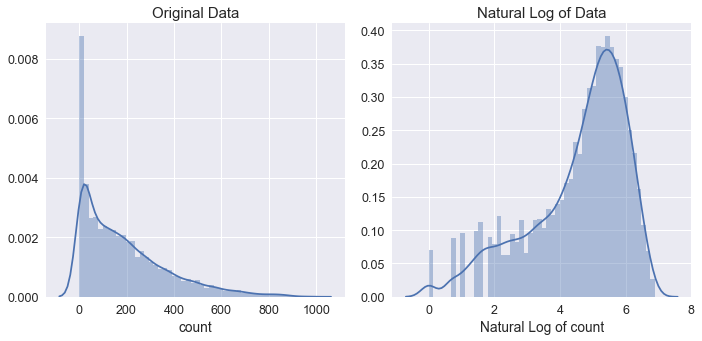

In [89]:
target_log = np.log(target)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel(label)

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of ' + label)
plt.tight_layout()

### Feature correlation

In [58]:
data.dtypes

season                   int64
holiday                  int64
workingday               int64
weather                  int64
temp                   float64
atemp                  float64
humidity                 int64
windspeed              float64
datetime_obj    datetime64[ns]
year                     int64
month                    int64
day                      int64
hour                     int64
count                    int64
dtype: object

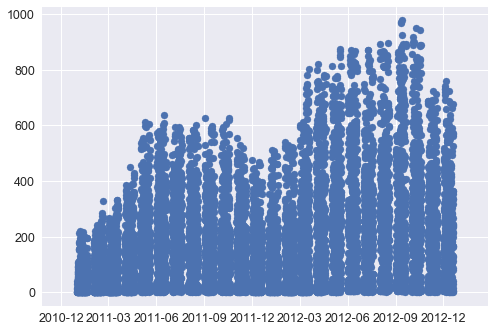

In [128]:
# datetime_obj vs label
plt.scatter(data['datetime_obj'].values,target)

In [235]:
correlation = data.corr()[label].sort_values()[-20:]
correlation

humidity     -0.317371
weather      -0.128655
holiday      -0.005393
weekday      -0.002283
workingday    0.011594
day           0.019826
windspeed     0.101369
season        0.163439
month         0.166862
year          0.260403
atemp         0.389784
temp          0.394454
hour          0.400601
count         1.000000
Name: count, dtype: float64

['count' 'hour' 'temp' 'atemp' 'year' 'month' 'season' 'windspeed' 'day'
 'workingday' 'weekday' 'holiday' 'weather' 'humidity']


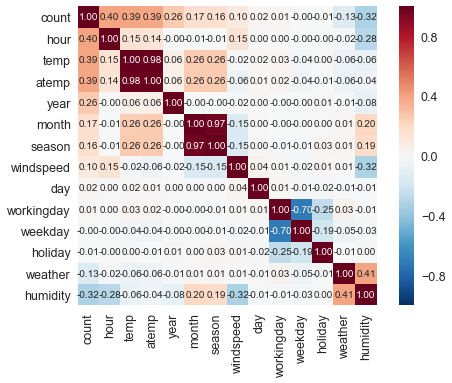

In [236]:
#correlation matrix
corrmat = data.corr()
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, label)[label].index
print(cols.values)
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

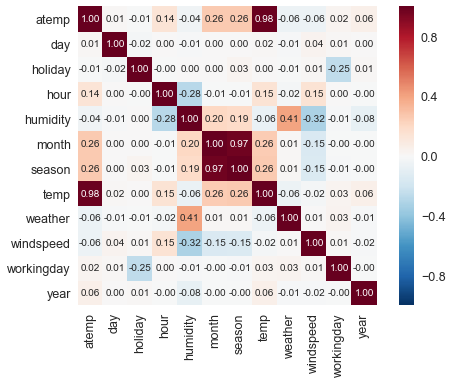

In [117]:
# Correlation matrix of cols except label
other_cols = np.setdiff1d(cols.values, label)
cm = np.corrcoef(data[other_cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=other_cols, xticklabels=other_cols)
plt.show()

### Season vs month

In [122]:
data['season'].describe()

count    10886.000000
mean         2.506614
std          1.116174
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: season, dtype: float64

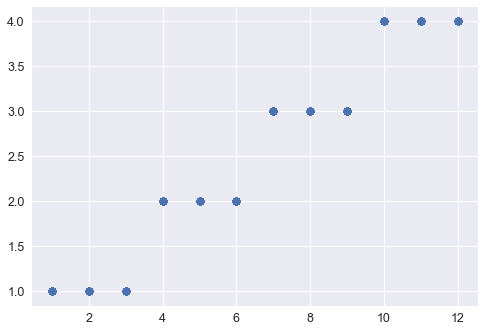

In [125]:
plt.scatter(data['month'],data['season'])

### Holiday

In [130]:
data['holiday'].describe()

count    10886.000000
mean         0.028569
std          0.166599
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: holiday, dtype: float64

In [168]:
data[data['holiday']==1][:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
372,1.0,1.0,0.0,2.0,8.20,9.850,47.0,15.0013,2011.0,1.0,17.0,0.0
373,1.0,1.0,0.0,2.0,8.20,9.850,44.0,12.9980,2011.0,1.0,17.0,1.0
374,1.0,1.0,0.0,2.0,7.38,8.335,43.0,16.9979,2011.0,1.0,17.0,2.0
375,1.0,1.0,0.0,2.0,7.38,9.090,43.0,12.9980,2011.0,1.0,17.0,3.0
376,1.0,1.0,0.0,2.0,7.38,9.850,43.0,8.9981,2011.0,1.0,17.0,4.0


# Feature engineering

In [169]:
data_fe = train_set.copy()
data_fe[label] =target_log
data_fe[:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime_obj,year,month,day,hour,count
0,1,0,0,1,9.84,14.395,81,0.0,2011-01-01 00:00:00,2011,1,1,0,2.772589
1,1,0,0,1,9.02,13.635,80,0.0,2011-01-01 01:00:00,2011,1,1,1,3.688879
2,1,0,0,1,9.02,13.635,80,0.0,2011-01-01 02:00:00,2011,1,1,2,3.465736
3,1,0,0,1,9.84,14.395,75,0.0,2011-01-01 03:00:00,2011,1,1,3,2.564949
4,1,0,0,1,9.84,14.395,75,0.0,2011-01-01 04:00:00,2011,1,1,4,0.000000


### Hour of month

In [175]:
col1 = 'hour'
col2 = 'day'
new_col = 'hour_month'
data_fe[new_col] = data_fe.apply(lambda row: row[col1]+ row[col2]*24, axis=1)
#train_set[new_col] = train_set.apply(lambda row: row[col1]+ row[col2]*24, axis=1)
#eval_set[new_col] = train_set.apply(lambda row: row[col1]+ row[col2]*24, axis=1)
print(data_fe[new_col][:5])
correlation = data_fe[[label,new_col, col1, col2]].corr()[label]
correlation

0    24
1    25
2    26
3    27
4    28
Name: hour_month, dtype: int64


count         1.000000
hour_month    0.049262
hour          0.568961
day           0.019396
Name: count, dtype: float64

In [176]:
col1 = 'hour'
col2 = 'day'
col3 = 'month'
new_col = 'hour_year'
data_fe[new_col] = data_fe.apply(lambda row: row[col1]+ row[col2]*24 + row[col3]*24*30, axis=1)
#train_set[new_col] = train_set.apply(lambda row: row[col1]+ row[col2]*24 + row[col3]*24*30, axis=1)
#eval_set[new_col] = eval_set.apply(lambda row: row[col1]+ row[col2]*24 + row[col3]*24*30, axis=1)
print(data_fe[new_col][:5])
correlation = data_fe[[label,new_col, col1, col2, col3]].corr()[label]
correlation

0    744
1    745
2    746
3    747
4    748
Name: hour_year, dtype: int64


count        1.000000
hour_year    0.166628
hour         0.568961
day          0.019396
month        0.164262
Name: count, dtype: float64

# Train model

In [237]:
data = train_set.drop('datetime_obj', axis=1).astype(float)

In [238]:
data[:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,2011.0,1.0,1.0,0.0,5.0
1,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,1.0,5.0
2,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,2.0,5.0
3,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,3.0,5.0
4,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,4.0,5.0


In [99]:
Y_train[:5]

array([ 4.09434456,  5.85793315,  5.84354442,  5.35185813,  3.40119738])

## Model definition & training

In [70]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# credit: https://www.kaggle.com/marknagelberg/rmsle-function
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(math.fabs(y_pred[i]) + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    #for i, pred in enumerate(y_pred):
    #    print("i:", i, " pred:", y_pred[i])
    #    print(math.log(y_pred[i] + 1))
    #    print(math.log(y[i] + 1))
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [239]:
#model = CatBoostRegressor(iterations=100, depth=5, thread_count=4, use_best_model=True)
model = XGBRegressor(n_estimators=1000, max_depth=5, n_jobs = -1)

### Find the best hyperparam for model using GridSearchCV

In [244]:
param_grid = {"max_depth"         : [1,5,10],
              'learning_rate'     :[0.1, 0.03, 0.01],
              'min_child_weight':  [1, 2, 5, 10]
             }
grid_search = GridSearchCV(model, param_grid, n_jobs=1, cv=5)
grid_search.fit(data, target_log)
print(grid_search.best_params_)

{'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.03}


### Tuning param after GridSearchCV

In [245]:
model.set_params(**grid_search.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=490,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Cross validate

In [248]:
dtrain = xgb.DMatrix(data,label=target_log, feature_names=data.columns.values)
params = model.get_xgb_params()
cvresults = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=50, verbose_eval=50)

[0]	train-rmse:4.19105+0.00283334	test-rmse:4.19107+0.0110765
[50]	train-rmse:1.04652+0.0031543	test-rmse:1.05292+0.00383617
[100]	train-rmse:0.445749+0.001854	test-rmse:0.465128+0.0100429
[150]	train-rmse:0.348778+0.00321539	test-rmse:0.37744+0.0101169
[200]	train-rmse:0.315091+0.00533712	test-rmse:0.349526+0.00715184
[250]	train-rmse:0.296636+0.00537332	test-rmse:0.334983+0.00700605
[300]	train-rmse:0.285604+0.00414559	test-rmse:0.327352+0.00761409
[350]	train-rmse:0.277957+0.00336126	test-rmse:0.323221+0.00817693
[400]	train-rmse:0.271165+0.00347135	test-rmse:0.319841+0.0081171
[450]	train-rmse:0.265932+0.00323119	test-rmse:0.317496+0.00821418
[500]	train-rmse:0.261207+0.00335972	test-rmse:0.315779+0.00792009
[550]	train-rmse:0.256928+0.00296174	test-rmse:0.31453+0.00805241
[600]	train-rmse:0.252489+0.00221999	test-rmse:0.312967+0.00844322
[650]	train-rmse:0.248435+0.00235934	test-rmse:0.312218+0.00821031
[700]	train-rmse:0.245227+0.0025641	test-rmse:0.311643+0.00838421
[750]	train-

In [249]:
print(cvresults.shape[0])
print(cvresults[-5:])
#print(cvresults.index.values)

1597
      test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
1592        0.306424       0.007565         0.202305        0.002672
1593        0.306413       0.007556         0.202267        0.002678
1594        0.306400       0.007572         0.202232        0.002664
1595        0.306407       0.007571         0.202207        0.002685
1596        0.306397       0.007583         0.202165        0.002690


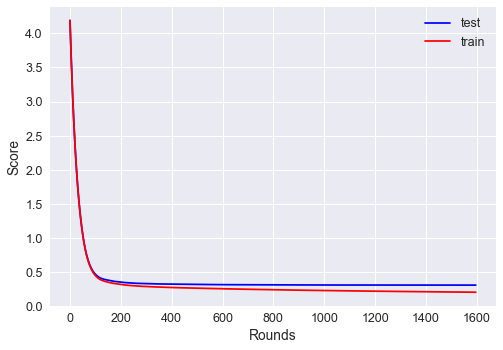

In [250]:
# plot cross validate
plt.plot(cvresults.index.values, cvresults['test-rmse-mean'], c='b', label='test')
plt.plot(cvresults.index.values, cvresults['train-rmse-mean'], c='r', label='train')
plt.xlabel('Rounds')
plt.ylabel('Score')
plt.legend()
plt.show()


### Tuning param after CV

In [251]:
model.set_params(n_estimators=cvresults.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=1597,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Plot learning curve to determine best train/test split

In [208]:
def plot_learning_curve(X, Y):
    plt.figure(figsize=(20,10))
    plt.title("Learing curve")
    # if ylim is not None:
    #     plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(model, X, Y)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

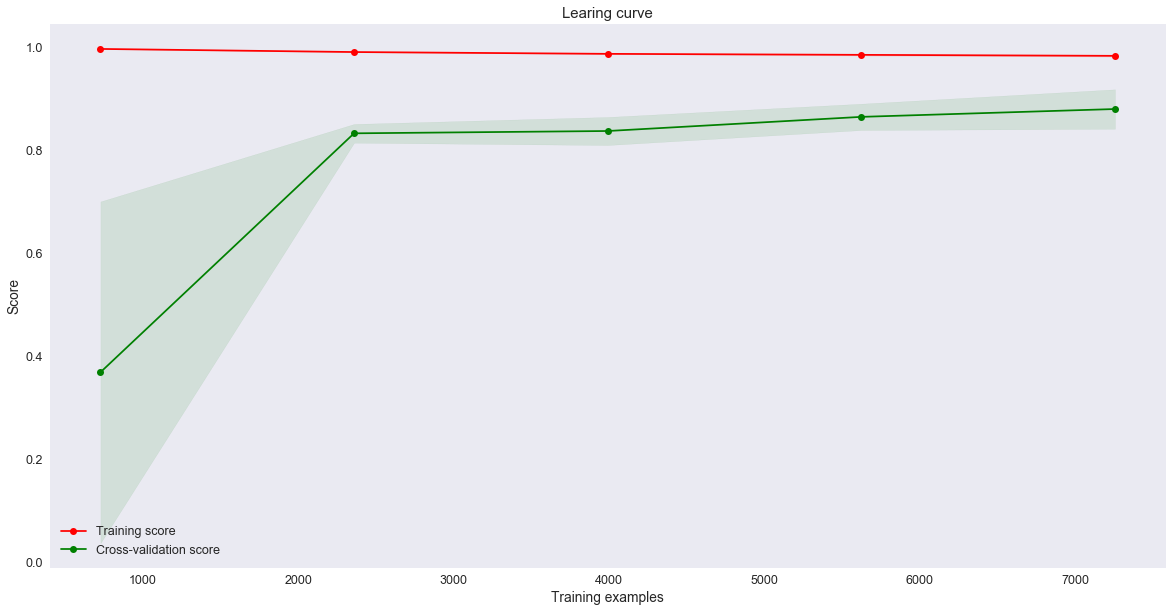

In [252]:
plot_learning_curve(data, target_log)

### Split train/test set

In [253]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target_log, train_size=0.85, random_state=1234)
print("X_train:", X_train.shape, " Y_train:", Y_train.shape, " X_test:", X_test.shape, " Y_test:", Y_test.shape)
X_train[:5]

X_train: (9253, 13)  Y_train: (9253,)  X_test: (1633, 13)  Y_test: (1633,)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
7973,2.0,0.0,1.0,3.0,26.24,28.790,89.0,16.9979,2012.0,6.0,12.0,14.0,1.0
2514,2.0,0.0,0.0,3.0,27.88,31.820,83.0,19.0012,2011.0,6.0,12.0,16.0,6.0
8668,3.0,0.0,1.0,2.0,35.26,40.150,47.0,19.0012,2012.0,8.0,3.0,13.0,4.0
9173,3.0,0.0,1.0,1.0,33.62,39.395,56.0,7.0015,2012.0,9.0,5.0,14.0,2.0
4822,4.0,0.0,1.0,1.0,18.86,22.725,59.0,19.0012,2011.0,11.0,14.0,0.0,0.0


### Train data

In [254]:
model.fit(
    X_train, Y_train,   
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=1597,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Predict for test data

In [255]:
y_pred = model.predict(X_test)

In [256]:
# Evaluate score
print(y_pred[:5])
score = rmsle(Y_test, y_pred)
print("RMSLE score:", score)

[ 5.34161806  4.41765404  4.53936005  1.61217463  5.77588844]
RMSLE score: 0.1082141854376401


### Feature importances

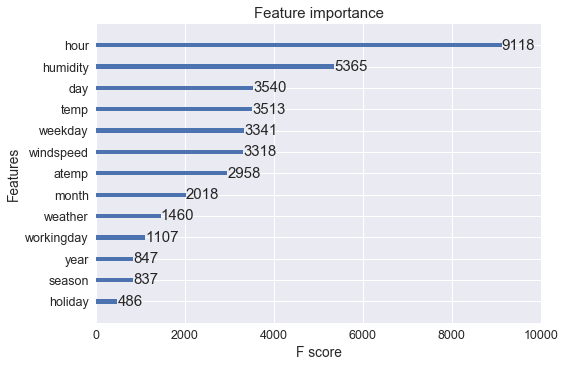

In [257]:
plot_importance(model)
plt.show()

In [188]:
model_params = model.get_params()
model_params

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 567,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [189]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    #print("X_train:", X_train.shape, " X_test:", X_test.shape)
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor()
    selection_model.set_params(**model_params)
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    score = rmsle(Y_test, y_pred)
    print("Thresh=%.3f, n=%d, Score: %.2f%%" % (thresh, select_X_train.shape[1], score))

Thresh=0.007, n=14, Score: 0.12%
Thresh=0.010, n=13, Score: 0.12%
Thresh=0.013, n=12, Score: 0.12%
Thresh=0.014, n=11, Score: 0.11%
Thresh=0.019, n=10, Score: 0.11%
Thresh=0.038, n=9, Score: 0.12%
Thresh=0.045, n=8, Score: 0.12%
Thresh=0.049, n=7, Score: 0.16%
Thresh=0.075, n=6, Score: 0.16%
Thresh=0.108, n=5, Score: 0.16%
Thresh=0.123, n=4, Score: 0.17%
Thresh=0.128, n=3, Score: 0.17%
Thresh=0.170, n=2, Score: 0.20%
Thresh=0.202, n=1, Score: 0.28%


# Predict and save submission

In [258]:
data = eval_set.drop('datetime_obj', axis=1).astype(float)
Y_eval_log = model.predict(data)
Y_eval = np.exp(Y_eval_log.ravel())
print(Y_eval_log[:5])
print(Y_eval[:5])

[ 2.30123353  1.44256282  1.07916021  0.65330034  0.49184653]
[ 9.98649311  4.23152637  2.94220757  1.92187321  1.63533318]


In [259]:
eval_output = pd.DataFrame({'datetime': eval_data['datetime'], 'count': Y_eval})
print(len(eval_output))
eval_output.head()

6493


,count,datetime
0,9.986493,2011-01-20 00:00:00
1,4.231526,2011-01-20 01:00:00
2,2.942208,2011-01-20 02:00:00
3,1.921873,2011-01-20 03:00:00
4,1.635333,2011-01-20 04:00:00


In [260]:
today = str(dt.date.today())
print(today)
eval_output.to_csv(DATA_DIR +'/' +today+'-submission.csv',index=False)

2017-07-21
